In [53]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma #gamma function
from scipy.integrate import simps


# constants cgs units 
c = 2.998e10 # cm/s 
eta = 0.1 # big n looking thing, no units
q = 5e-10 # eso # cgs units # charge of an electron
m_e = 9.109e-28 # mass of electron in grams
G = 6.67e-8 # cgs units
solar_mass = 1.989e+33 # grams
m_sgrA = 4.31e6 # solar mass
cross_section = 7e-25   #cm^2
m_p =  1.6726e-24 # g



#####
p = 2 # given in problem

erg_to_mjy = 1e26 # conversion factor from ergs /s to mJy

### Problem 4 Coding section:

Write a code for the light-curve of this expanding blob (intensity vs. time) and make a plot
of your results. Normalise assuming equipartition for Sgr A* in order to be able to get your
answer in physical units, and convert to mJy for the intensity unit on the y-axis.

* note to marker
no idea what the normalization part meant, I'm going to leave my Y axis in CGS units. I know my result is wrong anyway

In [50]:

# fuctions

def radius_t(t, beta, R_0):
    """
    Calculate the radius of an expanding blob at time t.

    Parameters:
    - t (float): Time.
    - beta (float): Expansion parameter frac of c.
    - R_0 (float): Initial radius.

    Returns:
    float: Radius at time t.
    """
    return  R_0 + beta*c *t

def constant_t(t, beta, R_0):
    """
    Calculate a constant value used in other calculations.

    Parameters:
    - t (float): Time.
    - beta (float): Expansion parameter.
    - R_0 (float): Initial radius.

    Returns:
    float: Constant value.
    """
    r = radius_t(t, beta, R_0)
    constant = (eta * L_edd * R_0**3) / (24 *np.log(10) * np.pi * r**3 *c**3*beta)
    return constant

def u_b(t, beta, R_0):
    '''
    Calculates the energy density caused by magnetisim
    Parameters:
    - t (float): Time.
    - beta (float): Expansion parameter.
    - R_0 (float): Initial radius.

    Returns:
    float: energy density caused by magnetisim.
    """'''
    r = radius_t(t, beta, R_0)
    my_ub = (eta * L_edd) / (8 *r**3 *c*beta)
    return my_ub


def alpha_v(t, beta, R_0, freq, alpha=0.5 * np.pi):

    """
    Calculate the absorption coefficient.

    Parameters:
    - t (float): Time.
    - beta (float): Expansion parameter.
    - R_0 (float): Initial radius.
    - freq (float): Frequency of radiation.
    - alpha (float, optional): Angle of observation. Defaults to 0.5 * np.pi.

    Returns:
    float: Absorption coefficient.
    """
    # absorption coef
    # equation 6.53 in the textbook
    term1 = (np.sqrt(3)* q**3) / (8 * np.pi * m_e )
    term2 = ((3*q) / (2*np.pi *m_e**3 *c**5))**(p/2)
    B = np.sqrt(u_b(t, beta, R_0) * 8 * np.pi)
    term3 = constant_t(t, beta, R_0) * (B *np.sin(alpha))**((p+2)/2)
    term4 = gamma((3*p+2 /12))
    term5 = gamma((3*p+22 /12))
    term6 = freq**(-1*(p+4)/2)

    return term1 * term2 * term3 * term4 * term5 * term6


def p_tot(t, beta, R_0, freq, alpha=0.5 * np.pi):
    """
    Calculate the total power per unit volume per unit frequency.

    Parameters:
    - t (float): Time.
    - beta (float): Expansion parameter.
    - R_0 (float): Initial radius.
    - freq (float): Frequency of radiation.
    - alpha (float, optional): Angle of observation. Defaults to 0.5 * np.pi.

    Returns:
    float: Total power per unit volume per unit frequency.
    """

    # equation 6.36 in the book
    # total power per unit volume per unit freq
    B = np.sqrt(u_b(t, beta, R_0) * 8 * np.pi)
    C = constant_t(t, beta, R_0)

    term1 = (np.sqrt(3)*q**3 *C *B * np.sin(alpha))/ (2 *np.pi* m_e*c**2 * (p+1))
    term2 = gamma(p/4 + 19/12)
    term3 = gamma(p/4 - 1/12)
    term4 = ((m_e*c*2*np.pi*freq)/(3*q*B*np.sin(alpha)))**(-(p-1)/2)
    return term1*term2*term3*term4



def source_function(t, beta, R_0, freq, alpha=0.5 * np.pi):
    """
    Calculate the source function.

    Parameters:
    - t (float): Time.
    - beta (float): Expansion parameter.
    - R_0 (float): Initial radius.
    - freq (float): Frequency of radiation.
    - alpha (float, optional): Angle of observation. Defaults to 0.5 * np.pi.

    Returns:
    float: Source function.
    """
    ## calculates the source function
    ## equation 6.54 

    obs_v = alpha_v(t, beta, R_0, freq, alpha=0.5 * np.pi)
    power_v = p_tot(t, beta, R_0, freq, alpha=0.5 * np.pi) / (4 *np.pi)

    return power_v / obs_v




def spefific_intenstiy(t, beta, R_0, freq, alpha=0.5 * np.pi):
    """
    Calculate the specific intensity.

    Parameters:
    - t (float): Time.
    - beta (float): Expansion parameter.
    - R_0 (float): Initial radius.
    - freq (float): Frequency of radiation.
    - alpha (float, optional): Angle of observation. Defaults to 0.5 * np.pi.

    Returns:
    float: Specific intensity.
    """

    S_v = source_function(t, beta, R_0, freq, alpha=0.5 * np.pi)
    r = radius_t(t, beta, R_0)
    tau = alpha_v(t, beta, R_0, freq, alpha=0.5 * np.pi) * r

    return S_v*(1-np.exp(-tau))

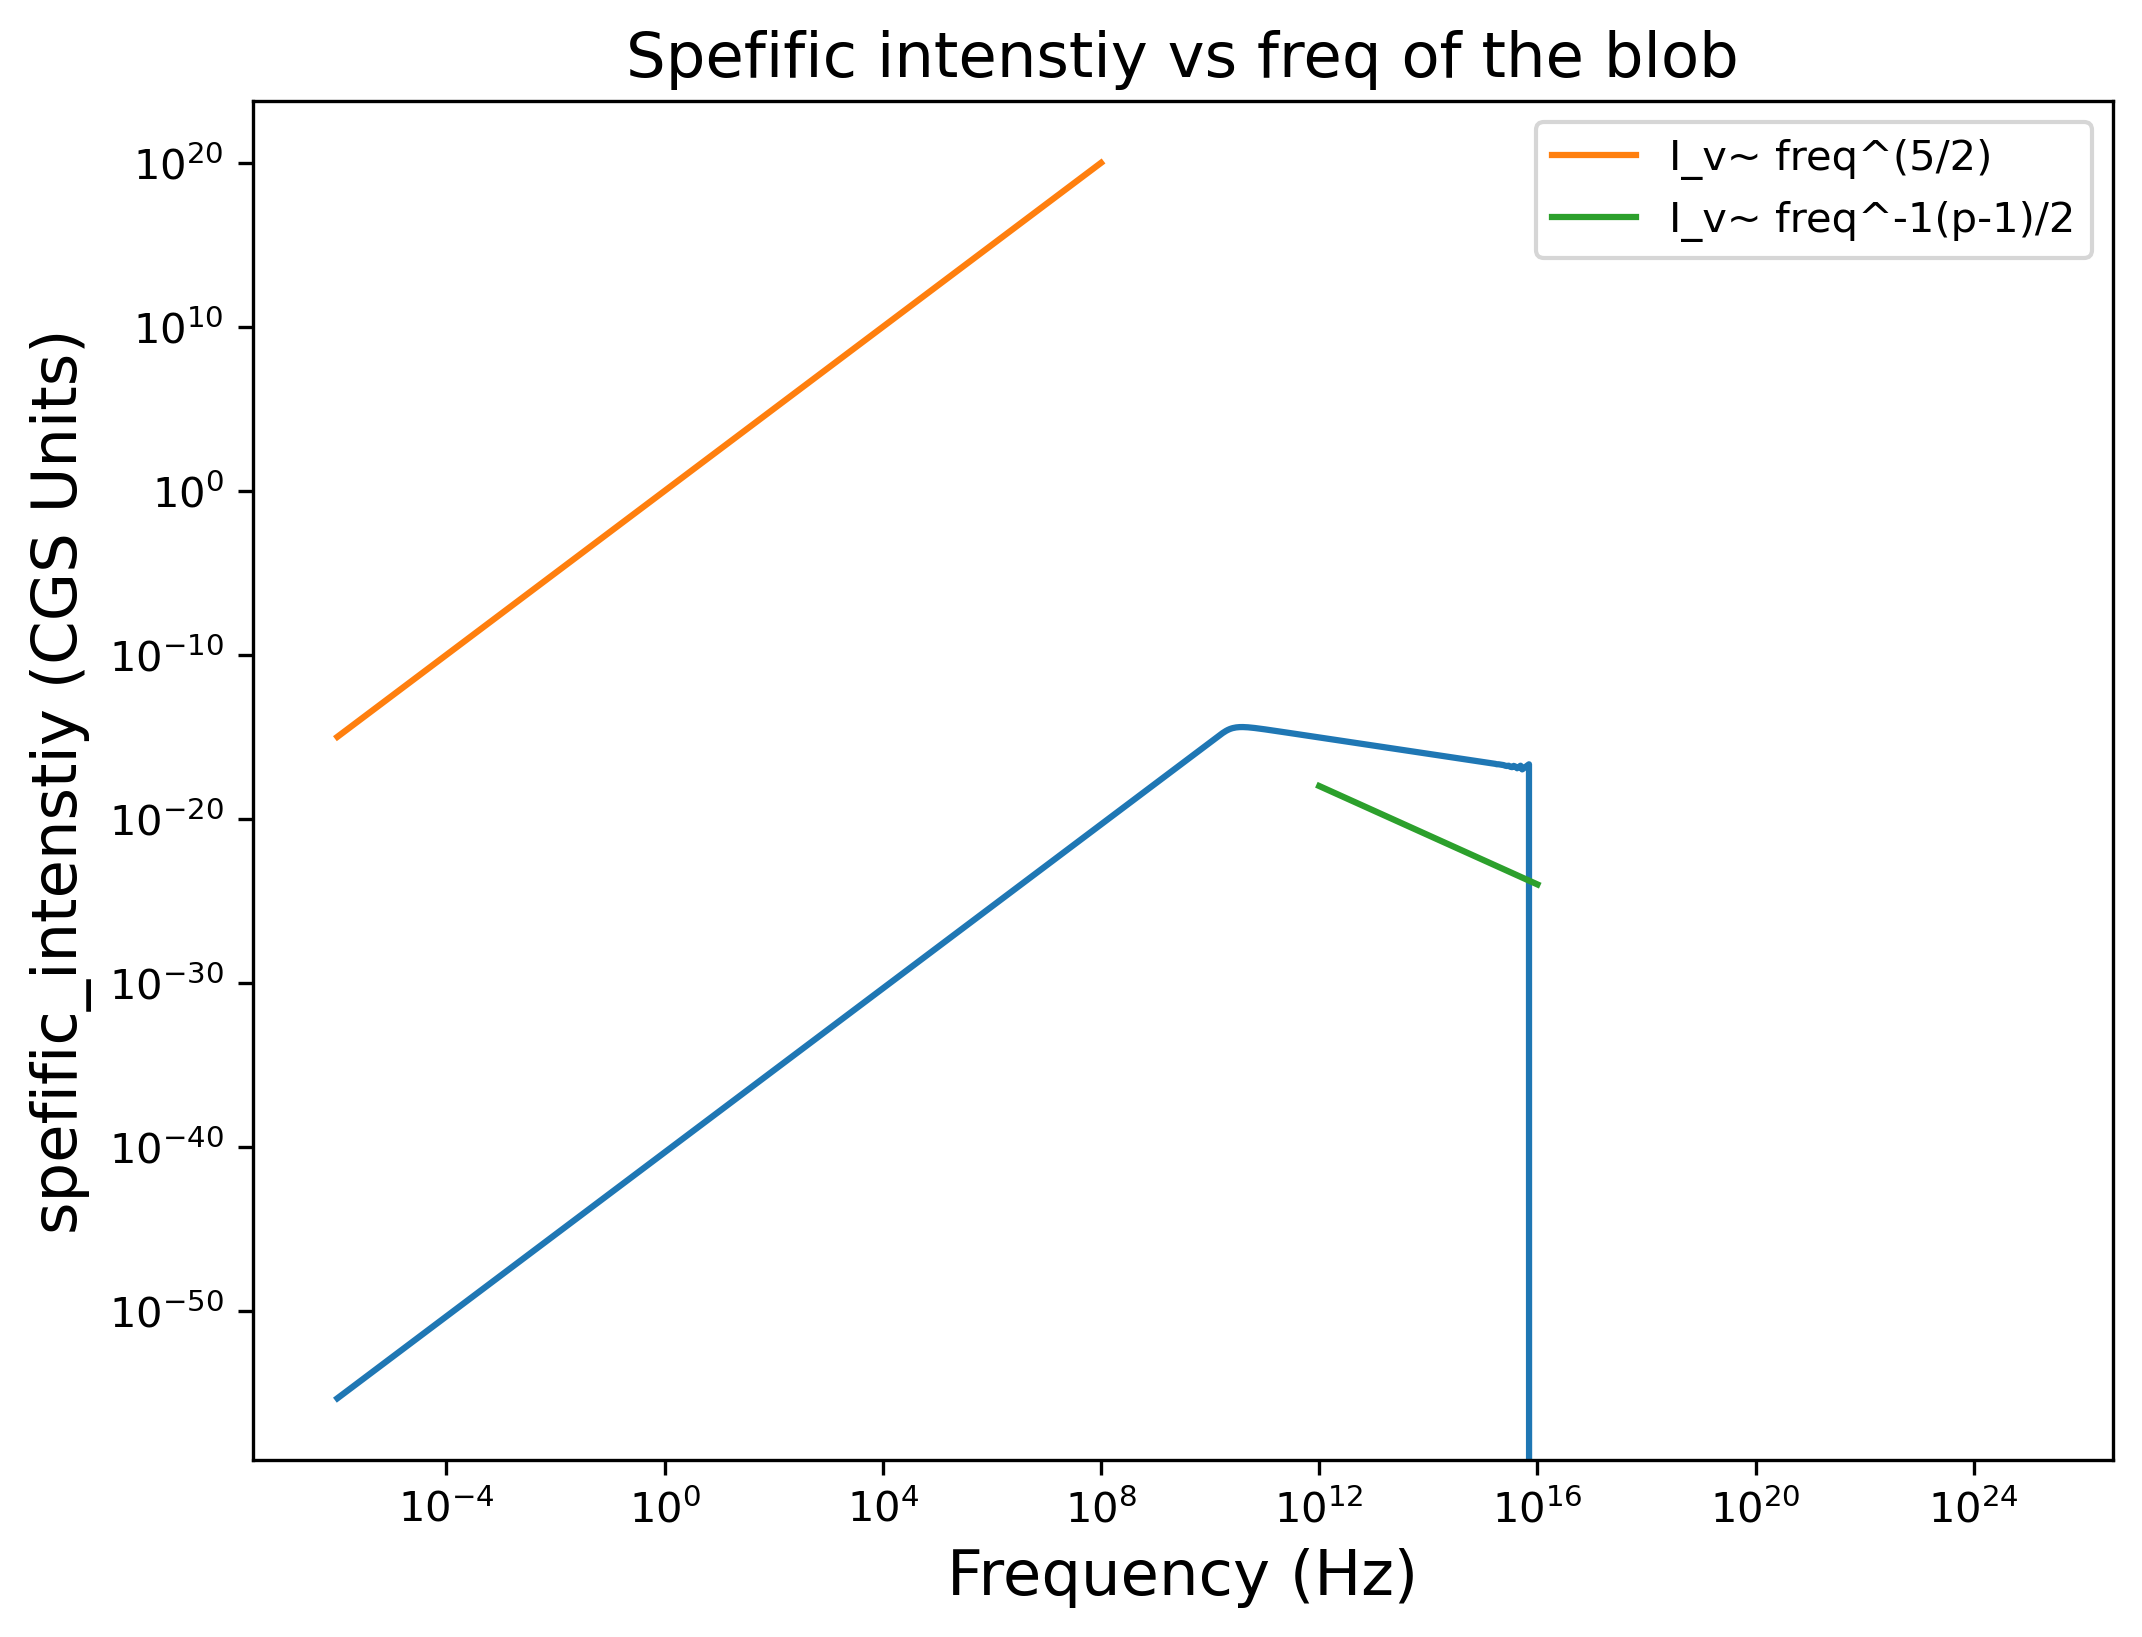

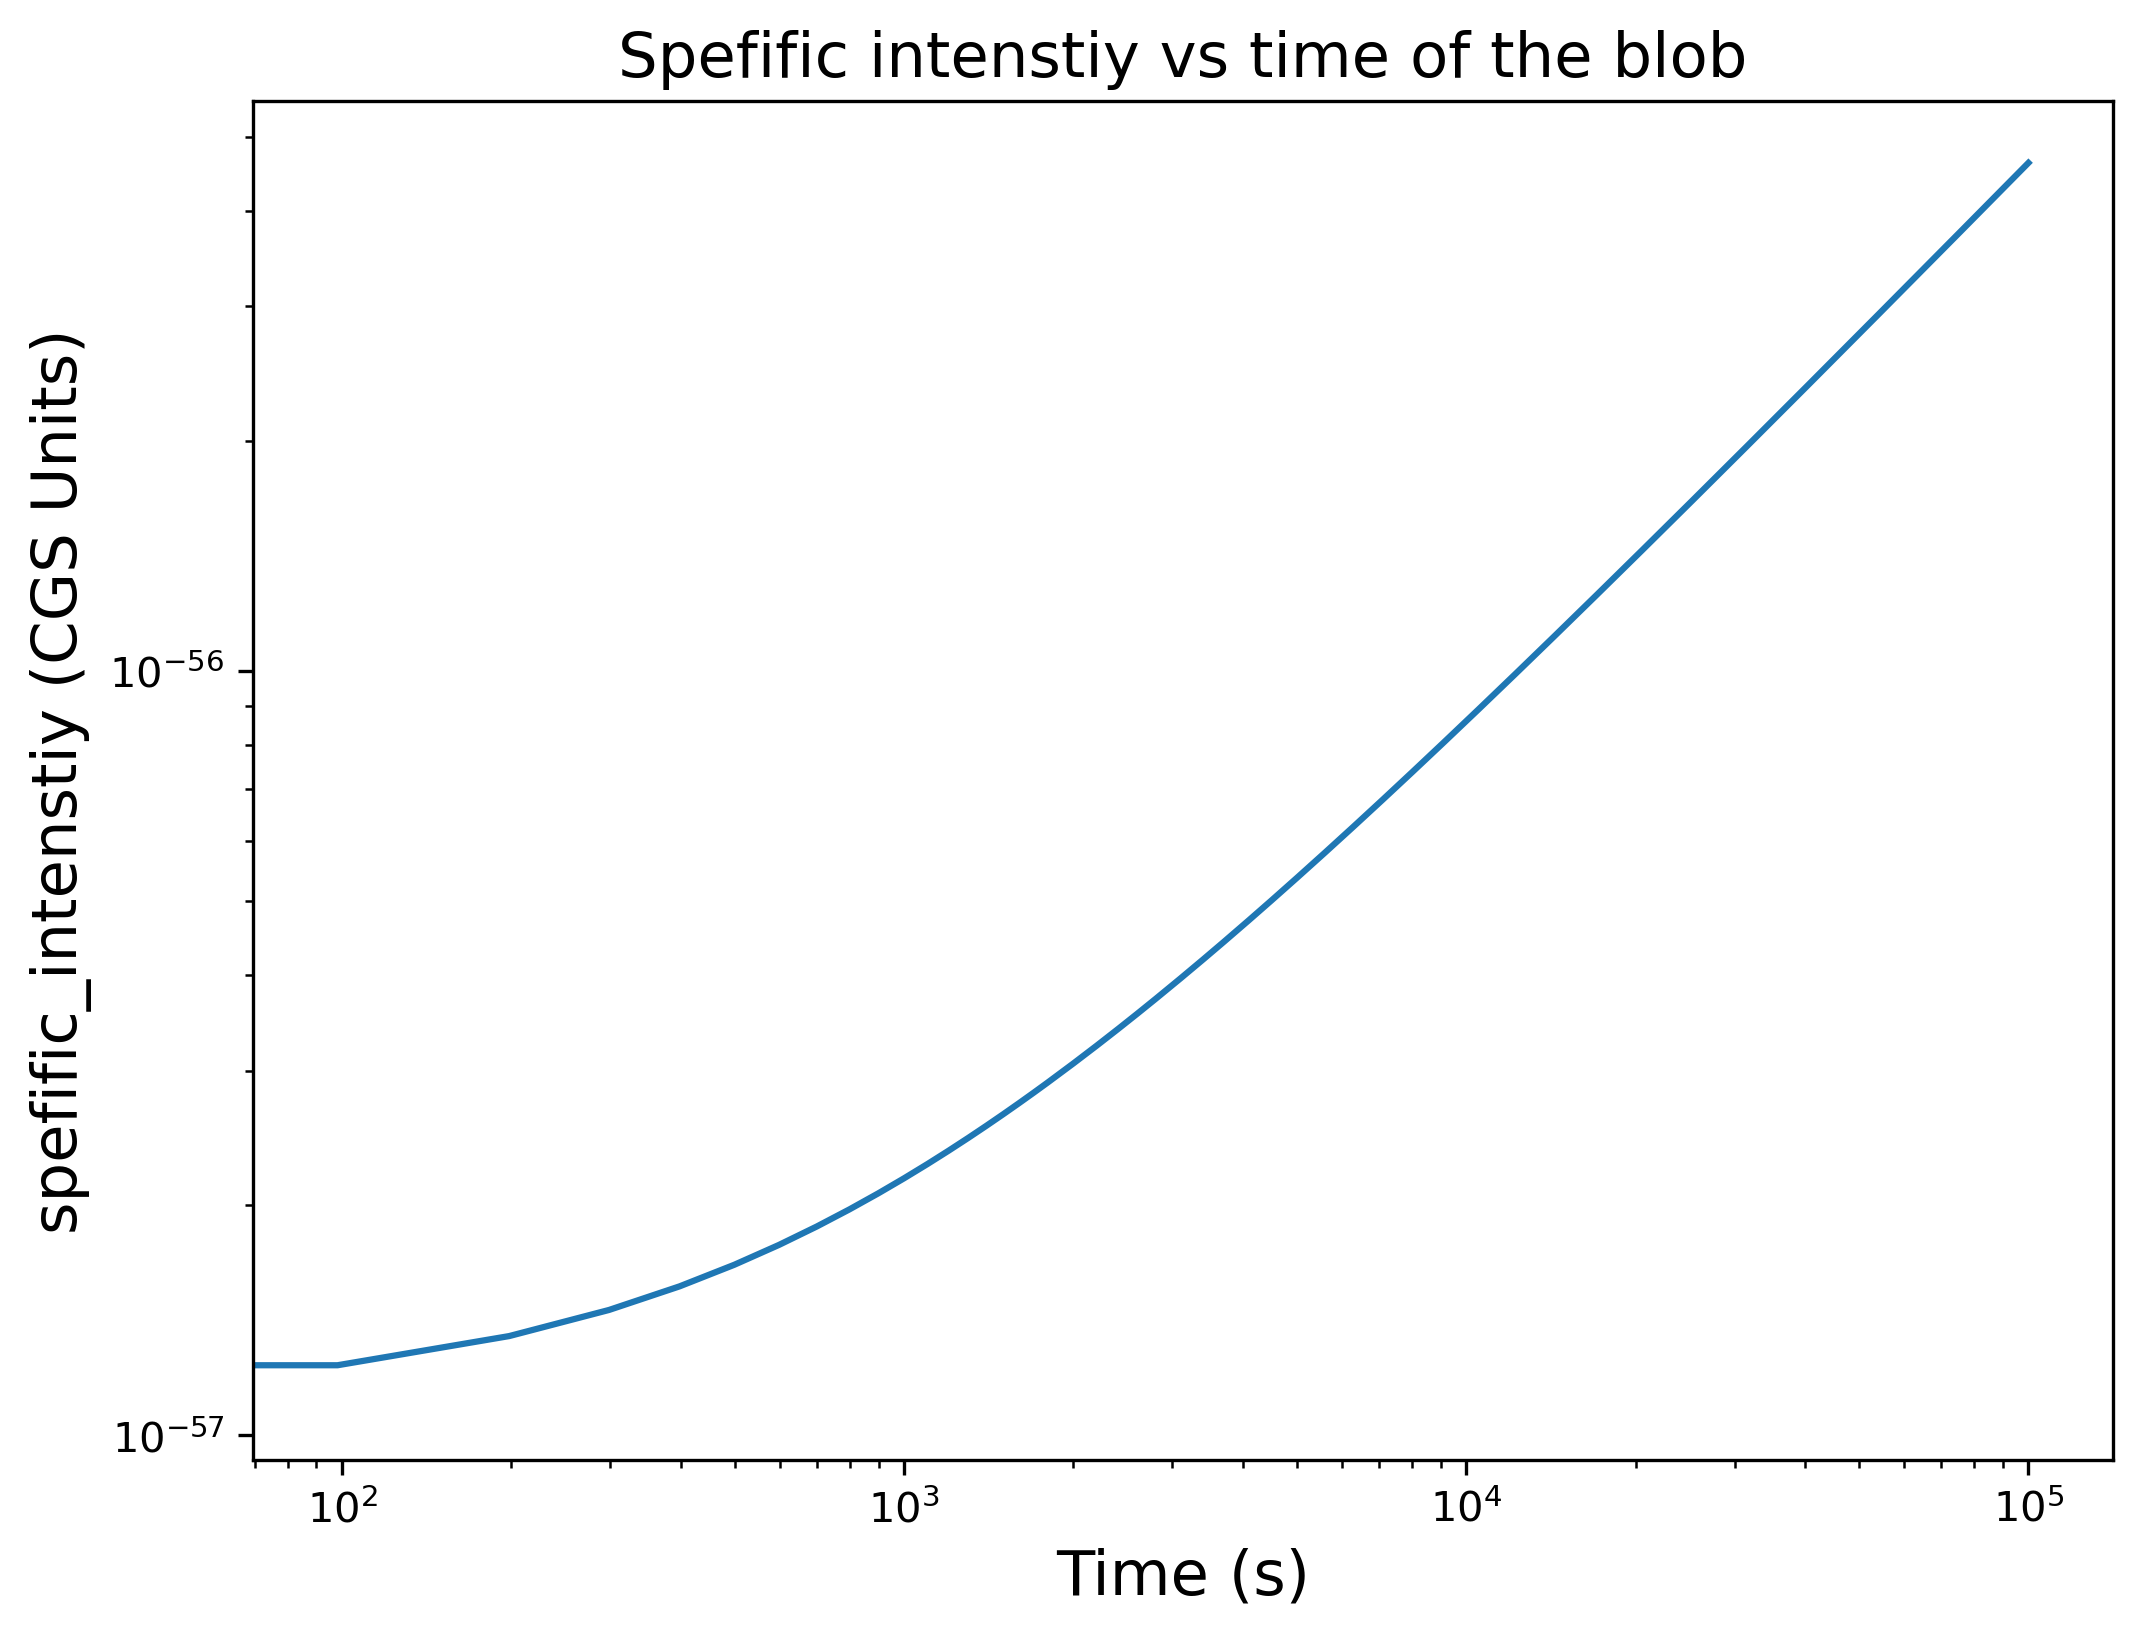

In [51]:
# in this cell we are running the functions and producing two plots.

# the first plot is the log(I_v) vs log(freq) so we can compare our results to figure 6.12 in the textbook

# the 2nd plot is the the lightcurve we are asked to produce 

t = np.linspace(-2, 100000, 1000)
t = t[:, None] # reshape vector
freq = np.logspace(-6, 25, 1000)
beta = 0.3 
R_0 = 10* (G * m_sgrA*solar_mass/ c**2)
L_edd = 4 * np.pi * G * m_sgrA*solar_mass *c *m_p/ cross_section
I_v = spefific_intenstiy(t, beta, R_0, freq, alpha=0.5 * np.pi)

plt.figure(figsize=(8,6), dpi=300)
plt.plot(freq, I_v[-1, :])

freq_test = np.logspace(-6, 8, 1000)
plt.plot(freq_test, freq_test**(5/2), label='I_v~ freq^(5/2)')

freq_test = np.logspace(12, 16, 100)
plt.plot(freq_test, freq_test**(-1 *( 3/2)), label='I_v~ freq^-1(p-1)/2')

plt.xlabel("Frequency (Hz)", size=15)
plt.ylabel('spefific_intenstiy (CGS Units)', size=15)
plt.title('Spefific intenstiy vs freq of the blob', size=15)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('hail_sagan_42069.pdf',bbox_inches='tight')

plt.show()

plt.figure(figsize=(8,6), dpi=300)
plt.plot(t, I_v[:, 0])

# need to integrate over I_v to get lightcurve

plt.xlabel("Time (s)", size=15)
plt.ylabel('spefific_intenstiy (CGS Units)', size=15)
plt.title('Spefific intenstiy vs time of the blob', size=15)
plt.yscale('log')
plt.xscale('log')
plt.savefig('hail_sagan_42069_time.pdf',bbox_inches='tight')




You might have noticed that these plots look ugly when compared to previous work that I have submitted. 
That is because I know they are wrong so I did not worry about making them look pretty. 

In the first figure log(I_v) vs log(freq) - so we can compare our results to figure 6.12 in the textbook the slope is incorrect for the optically thin regime! (The green line should have the same slope!) The optically thick (orange line) appears to have the correct slope. This is indicative that my solution for 4 is wrong. Hopefully it is just a algebra mistake somewhere, but I do not know or have time to fix this. At least I can tell you it is wrong. 

Becaus this plot is wrong, the lightcurve plot is automatically wrong as well!! :((

### Problem 5:

(e) Assuming a power-law in Cyg A of particles with index p = 2.2 normalised to assume
equipartition (Ue = UB), code up the synchrotron spectrum (in units of mJy again) by
starting with equations 6.21a&b from R&L for the total power radiated per unit volume
per unit frequency for a power-law of electrons. To make this easier, use the simplifying
assumption that F(x) is a delta function peaked at x = 0.3. You will need to estimate the
emitting volume and use the distance of 230Mpc.

(f) Do a simple brute-force numerical integration of your spectrum and verify that you get
the right total power!


equation 6.21b + delta function

$$P_{tot}(\omega) \sim \omega^{-(p-1)/2} 0.3^{(p-3)/2}$$

p =2.2

plugging in we get:

$$P_{tot}(\omega) \sim \omega^{-(1.2)/2} 0.3^{(2.2-3)/2}$$

This seems like we just plug in chug? right 


aaaah! but we dont know the normalization factor!

Idea $L= 4 F\pi D^2$ where F is the flux given by the galaxy, D is the distance to the galaxy. we are told $L \sim 10^{45} \mathrm(erg/s)$.

We can relate the total power to the flux and work backwards!

Flux = (P_tot / 4*pi ) * Surface area

In our case the effective surface area is a disk with a radius of the galaxy blob.

Since I am doing the normalization in this manner, the total emitted power already adds up as expected! (unless I made a mistake)



In [55]:
D = 230 *3.086e+24 #cm
m_cygA = 100000* 1e9 * solar_mass # grams
Surface_area = (G*m_cygA/ c**2)**2 * np.pi  # cm # a circle with 1 R_g, based on the mass of of Cyg A (entire galaxy is used here)

In [56]:
def power_f(f,):
    #assuming delta function peaked at 0.3 equation 6.21b

    power = (2*np.pi *f)**(-1.2/2) * 0.3**((2.2-3)/2)
    return power




# in order

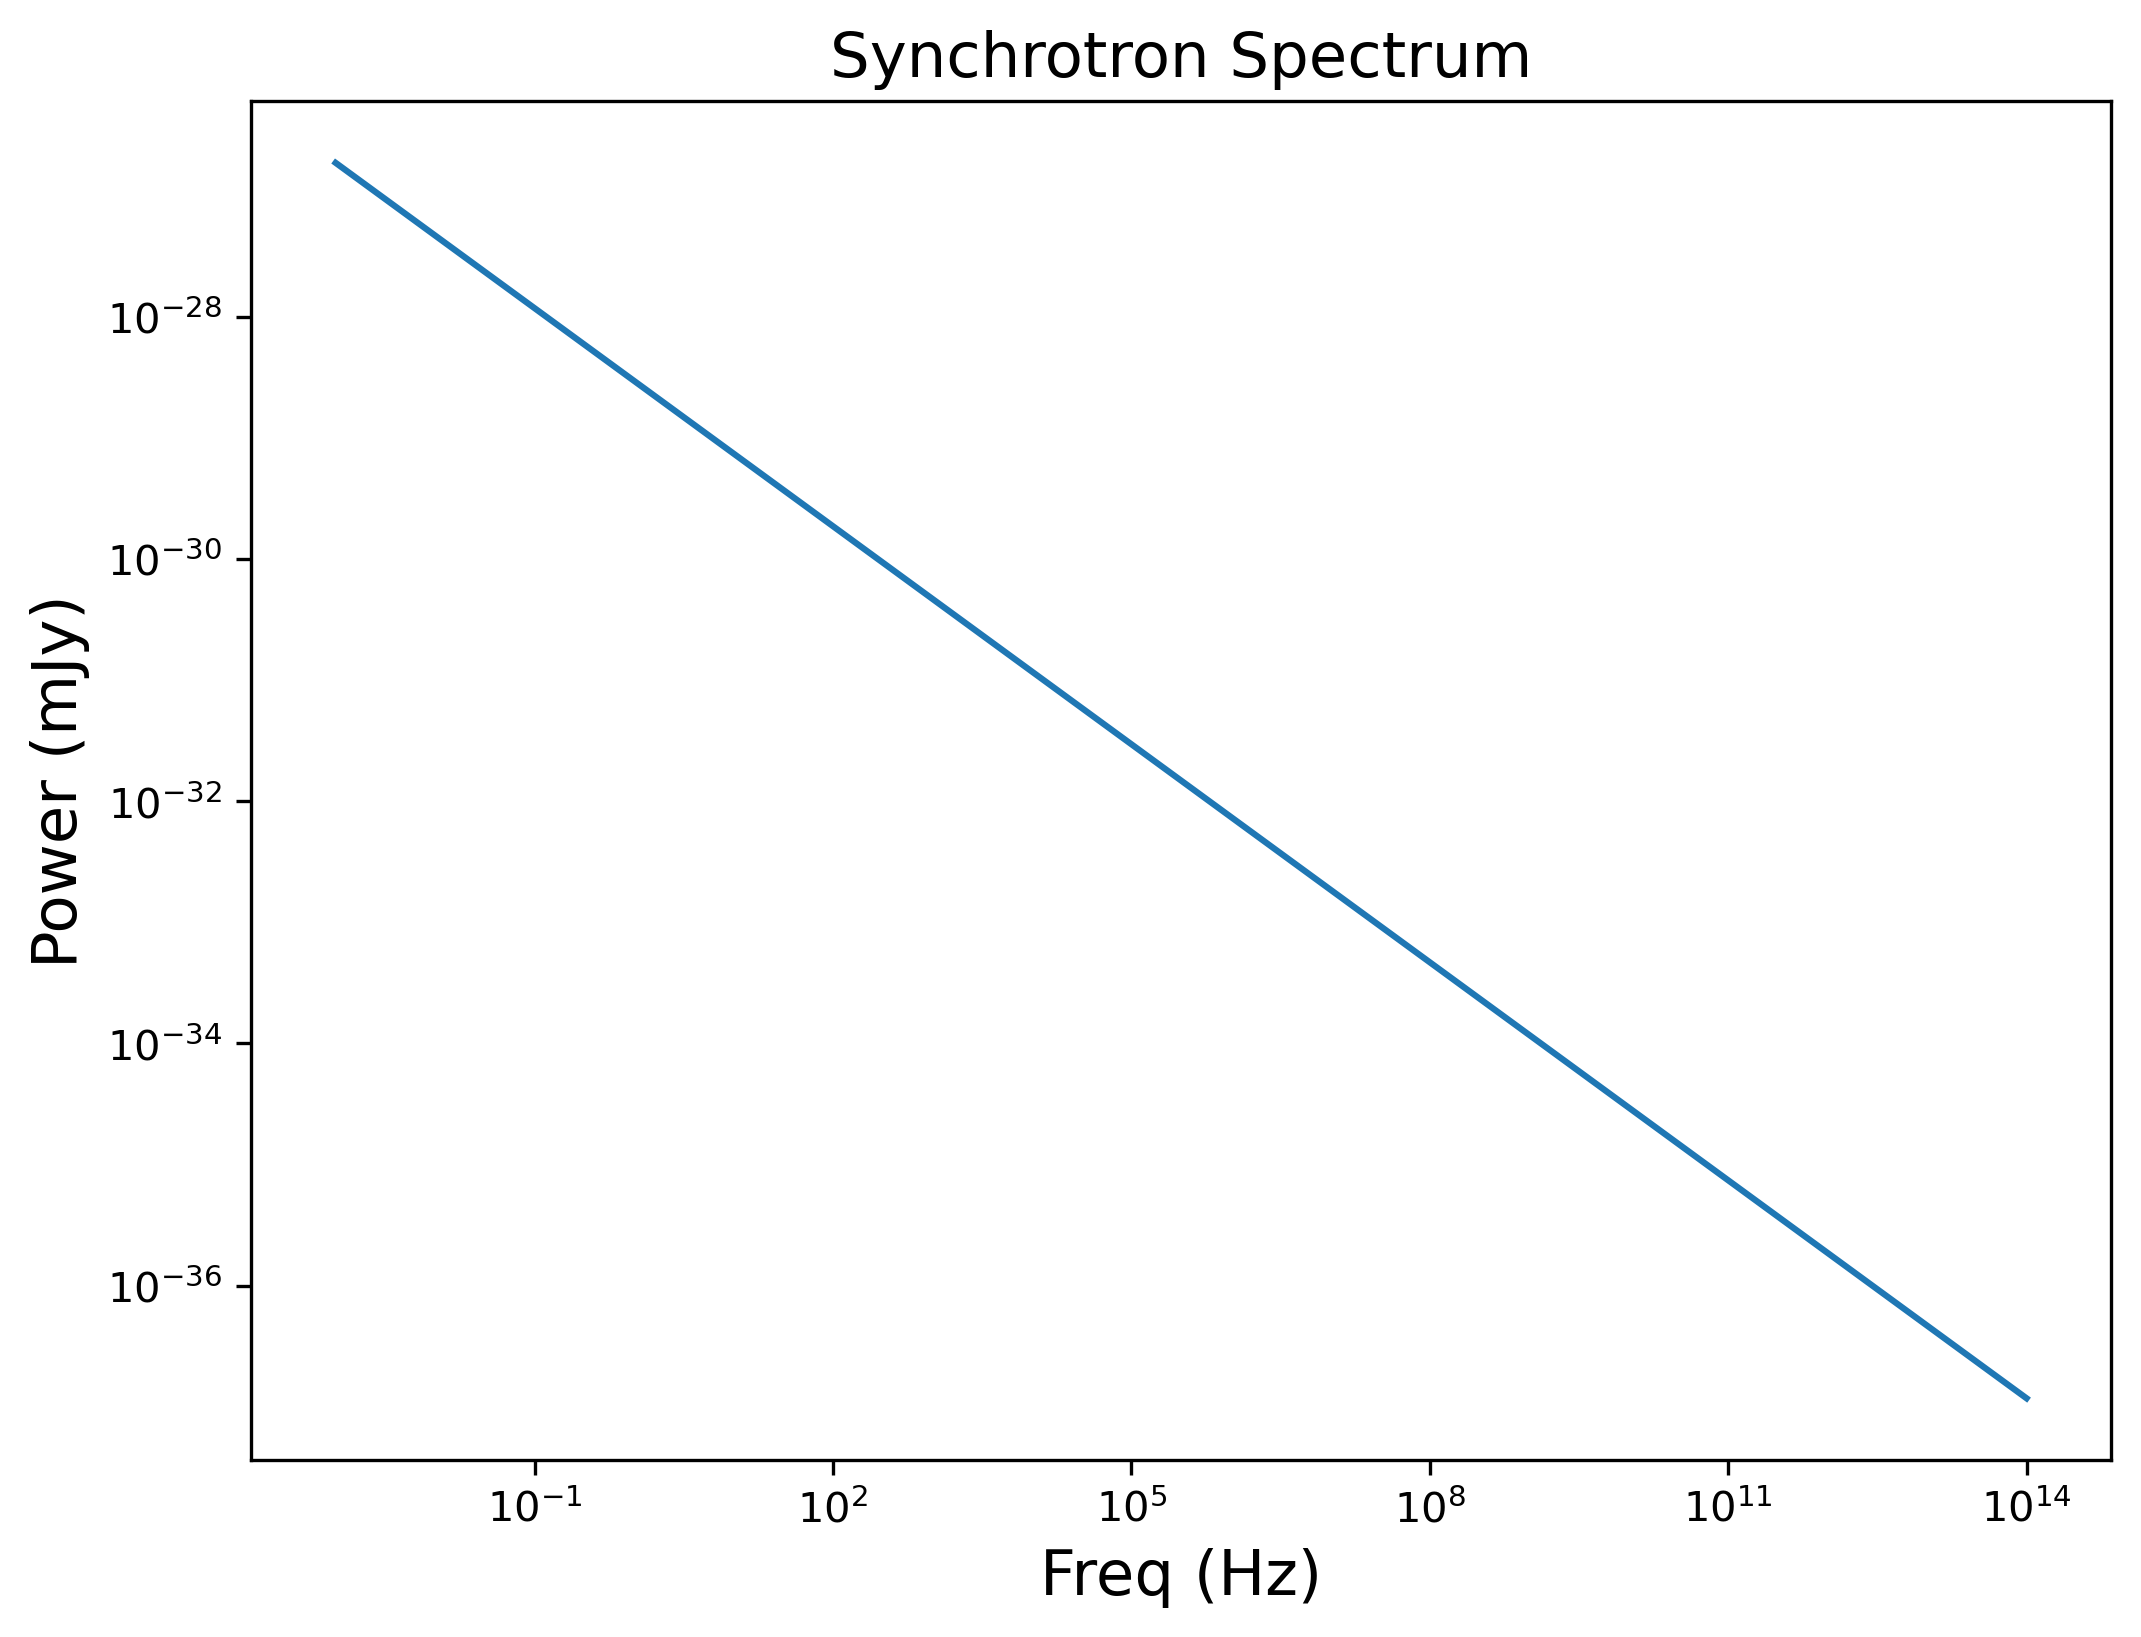

In [57]:
freq = np.logspace(-3, 14, 1000)
power = power_f(freq) # cgs units

# 1e45 total intergral of erg s-1

# normalize 
integral_simpson = simps(power, freq)

flux = (integral_simpson / 4 *np.pi)* Surface_area
L_calc = 4*flux*np.pi *D**2
normalization_factor = 1e45/L_calc


plt.figure(figsize=(8,6), dpi=300)
plt.plot(freq, power * normalization_factor *erg_to_mjy )#* 1e23)
plt.xlabel("Freq (Hz)", size=15)
plt.ylabel('Power (mJy)', size=15)
plt.title('Synchrotron Spectrum', size=15)
plt.yscale('log')
plt.xscale('log')


In [32]:
power